In [126]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['jobdesc', 'jddata', 'glove840b300dtxt', 'fasttext-crawl-300d-2m']


In [127]:
import pickle
import os
import time
import gc
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F

In [128]:
train=pd.read_csv("../input/jobdesc/proc_data.csv")

In [129]:
train.head()

,description,department
0,Urgent positions for Travel Executive at Saane...,Customer service
1,"Dear Candidate,Greetings From Continental Immi...",Sales
2,We Have urgent poitions for Ticketing Executiv...,Ticketing
3,We Have Urgent positions for Travel booking cu...,Customer service
4,Experience in Travel Industry.We have urgent o...,Ticketing


In [130]:
import os
print(os.listdir("../input"))

from keras.preprocessing import text, sequence
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import LearningRateScheduler
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
#from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F

['jobdesc', 'jddata', 'glove840b300dtxt', 'fasttext-crawl-300d-2m']


In [131]:
NUM_MODELS = 2 #??
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4*LSTM_UNITS #??
EPOCHS = 4
MAX_LEN = 220

In [132]:
TEXT_COLUMN = 'description'
TARGET_COLUMN = 'department'
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }


In [133]:
contraction_patterns = [(r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'),\
                        (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'),\
                        (r'(\w+)n\'t', '\g<1> not'),\
                        (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'),\
                        (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'),\
                        (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'),\
                        (r'wont', 'will not')]

def replace_contraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text


In [134]:
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    finalTokens = []
    #tokens = nltk.word_tokenize(text)
    for w in text.split():
        finalTokens.append(lemmatizer.lemmatize(w))
    text = " ".join(finalTokens)
    return text

In [135]:
stoplist = set(stopwords.words('english'))

In [160]:
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(train['description'].values):
    sentance = re.sub(r"http\S+", "", str(sentance))
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = replace_contraction(sentance)
    sentance = lemmatize_words(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stoplist)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 1162/1162 [00:01<00:00, 780.81it/s]


In [161]:
x_train=preprocessed_reviews

In [138]:
class_labels=list(train['department'].unique())

In [139]:
labels=pd.DataFrame({'label':class_labels,'index':range(len(class_labels))})
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
label    30 non-null object
index    30 non-null int64
dtypes: int64(1), object(1)
memory usage: 560.0+ bytes


In [140]:
train.iloc[0]

description    Urgent positions for Travel Executive at Saane...
department                                      Customer service
Name: 0, dtype: object

In [141]:
for ind,val in enumerate(class_labels):
    train['department']=np.where(train['department']==val,ind,train['department'])

In [142]:
train['department'][:5]


0    0
1    1
2    2
3    0
4    2
Name: department, dtype: object

In [143]:
from keras.utils import np_utils

Y_train=np_utils.to_categorical(train['department'],30)

In [144]:
Y_train[:5]

array([[1., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 1., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 1., 0., ..., 0., 0., 0., 0.],
       [1., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 1., 0., ..., 0., 0., 0., 0.]], dtype=float32)

In [157]:
y_train=Y_train[0:1000]
y_test=Y_train[1000:]

In [146]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [147]:
CRAWL_EMBEDDING_PATH = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '../input/glove840b300dtxt/glove.840B.300d.txt'

In [162]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) )
X_train=x_train
x_train = tokenizer.texts_to_sequences(X_train[0:1000])
x_test = tokenizer.texts_to_sequences(X_train[1000:])

x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test=sequence.pad_sequences(x_test,maxlen=MAX_LEN)


In [164]:
len(x_test)

162

In [165]:
max_features=None
max_features = max_features or len(tokenizer.word_index) + 1
max_features

5242

In [150]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

2000001it [02:58, 11176.25it/s]


n unknown words (crawl):  1458


In [151]:
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

2196018it [03:15, 11238.72it/s]


n unknown words (glove):  1462


In [152]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
embedding_matrix.shape

(5242, 600)

In [182]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(max_features,embedding_matrix.shape[1], weights=[embedding_matrix],input_length=MAX_LEN,trainable=False))
model.add(Dropout(0.5))
model.add(LSTM(LSTM_UNITS,return_sequences=True))
model.add(LSTM(LSTM_UNITS))
model.add(Dropout(0.5))
#model.add(LSTM(100))
model.add(Dense(4*LSTM_UNITS,activation='relu'))
model.add(Dense(4*LSTM_UNITS,activation='relu'))
model.add(Dense(30, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 220, 600)          3145200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 220, 600)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 220, 128)          373248    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
__________

In [191]:
history=model.fit(x_train, y_train, nb_epoch=30, batch_size=64,validation_data=(x_test,y_test))
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 1000 samples, validate on 162 samples
Epoch 1/30
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9379 - acc: 0.3130 - val_loss: 2.6542 - val_acc: 0.2099
Epoch 2/30
1000/1000 [==============================] - 15s 15ms/step - loss: 1.9013 - acc: 0.3130 - val_loss: 2.4886 - val_acc: 0.2099
Epoch 3/30
1000/1000 [==============================] - 15s 15ms/step - loss: 1.8625 - acc: 0.3130 - val_loss: 2.5218 - val_acc: 0.2099
Epoch 4/30
1000/1000 [==============================] - 15s 15ms/step - loss: 1.8169 - acc: 0.3130 - val_loss: 2.5011 - val_acc: 0.2099
Epoch 5/30
1000/1000 [==============================] - 15s 15ms/step - loss: 1.7830 - acc: 0.3130 - val_loss: 2.4743 - val_acc: 0.2099
Epoch 6/30
1000/1000 [==============================] - 15s 15ms/step - loss: 1.7522 - acc: 0.3120 - val_loss: 2.4090 - val_acc: 0.2037
Epoch 7/30
1000/1000 [==============================] - 15s 15ms/step - loss: 1.7574 - acc: 0.3160 - val_loss: 2.5392 - val_acc: 0.2099
E

In [184]:
scores = model.evaluate(x_train, y_train, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 31.30%


In [192]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

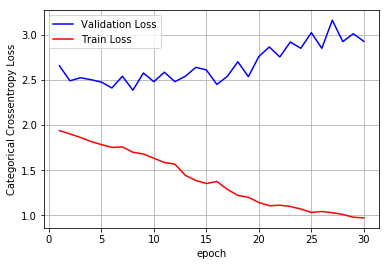

In [193]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,30+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [194]:
y_pred=model.predict(x_test)

In [187]:
y_pred[5].argsort()[29]

2

In [195]:
y_pred_hat=[]
for i in range(len(x_test)):
    y_pred_hat.append(y_pred[i].argsort()[29])
    
print(type(y_pred_hat))
y_pred_hat[:5]

<class 'list'>


[11, 11, 0, 2, 19]

In [196]:
y_act=list(train['department'][1000:])

In [197]:
from sklearn.metrics import confusion_matrix,f1_score
y_actual=train['department']
cnf_mat=confusion_matrix(y_act,y_pred_hat)
#f1=f1_score(y_act,y_pred_hat)

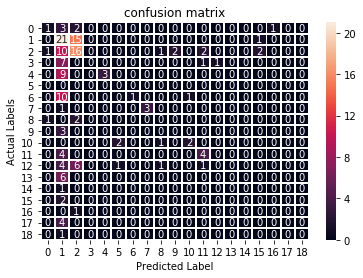

In [198]:
import seaborn as sn
heatmap=sn.heatmap(cnf_mat,linewidths=1,annot=True,fmt="d").set_title("confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Labels")
plt.show()